<h1 style="color:#2F659C";>Azog A1 measurement script</h1>
The cooled down chip is azog_a1, a resonators made of 1500 bridge free junctions.

In [2]:
sample_name = 'azog_a1'       # name of the chip in the fridge

user = 'ncr'                  # who is performing measurements
date = '20211014'             # when did the measurements started
description = 'resonator_dc'  # super short description of what you are doing

<h3 style="color:#418FDB";>QCodes imports</h3>
Import the QCodes functions used in the measurement of this sample.

In [3]:
import os
import sys
from time import sleep, perf_counter

import matplotlib.pyplot as plt
import numpy as np
import qcodes as qc
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
)

#from qcodes.utils.dataset.doNd import do0d, do1d, do2d, dond, plot, LinSweep, LogSweep

from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging, start_command_history_logger
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.interactive_widget import experiments_widget

In [4]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Scripts')
from QMETfunc.QMET_measurement import do0d, do1d, do2d, dond, LinSweep, LogSweep

data_dir = os.path.join(r'D:\QMET' + '\\' + sample_name)
<h2 style="color:#1C3C5C";>Station and database setup</h2>
Add the instruments to the station and start all the loggings related to the measurement. Then create or initialise the database where all the data will be saved.

In [4]:
data_dir = os.path.join(r'D:\QMET' + '\\' + sample_name)

<h3 style="color:#418FDB";>Station initialization</h3>

In [5]:
STATION = qc.Station()

start_all_logging()
start_command_history_logger(data_dir)

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\211014-13172-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : D:\QMET\azog_a1\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


<h3 style="color:#418FDB";>Database initialization</h3>

In [6]:
database_name = date + '_' + user + '_' + description
try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

qc.initialise_or_create_database_at(data_dir + '\\' + database_name + '.db')
qc.config.core.db_location

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.45it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.57it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 248.95it/s]


'D:\\QMET\\azog_a1\\20211014_ncr_resonator_dc.db'

<h3 style="color:#418FDB";>Instruments initialisation</h3>
Add to path the folder containing the drivers. Then import and connect to the used instruments, while delete the unused ones.

In [7]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Drivers')

<h4  style="color:#4697E8";>Connect to the Rohde&Schwartz VNA</h4>

In [8]:
from VNA_ZNB20 import ZNB
#from VNA_RS import ZNB
#from VNA_ZNB20 import ZNBChannel

try:
    vna = ZNB('ZNB20', 'TCPIP0::192.168.0.9::inst0::INSTR',
               init_s_params=False,terminator='\n')
except KeyError as er:
    ZNB.close_all() # Disconnect and irreversibly tear down the instrument
    vna = ZNB('ZNB20', 'TCPIP0::192.168.0.9::inst0::INSTR',
               init_s_params=False,terminator='\n')
    
vna.clear_channels()

vna.add_channel('S21', vna_parameter='S21');
s21 = vna.channels.S21

#vna.add_channel('S11', vna_parameter='S11');
#s11 = vna.channels.S11

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101579, firmware:2.94) in 0.07s


<h4 style="color:#4697E8";>Connect to the ADwin</h4>

In [9]:
from ADwin_Gold2 import ADwin_Gold2, adwin_Nramp

ad = ADwin_Gold2("adwin",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\ADwin11.btl",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\acquisition-gold2.TB1")

Connected to: None adwin (serial:None, firmware:None) in 0.27s


<h4 style="color:#4697E8";>Connect to the Agilent signal generator</h4>

In [10]:
from Agilent_E8257D import E8257D

try:
    mw_source = E8257D('mw_source','TCPIP0::192.168.0.70::inst0::INSTR')
except KeyError as er:
    E8257D.close_all()
    mw_source = E8257D('mw_source','TCPIP0::192.168.0.70::inst0::INSTR')

Connected to: Agilent Technologies E8257D (serial:US45470698, firmware:C.06.28) in 0.03s


<h4 style="color:#4697E8";>Connect to the Rohde&Schwartz signal generator</h4>

In [11]:
from RS_SMB_100A import SMB100A

#try:
#    mw_source_rs = SGS100A('pump_source','USB0::0x0AAD::0x0088::112061::INSTR')
#except KeyError as er:
#    SGS100A.close_all()
#    mw_source_rs = SGS100A('pump_source','USB0::0x0AAD::0x0088::112061::INSTR')

<h4 style="color:#4697E8";>Dummies</h4>

In [12]:
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

<h3 style="color:#418FDB";>Adding the instruments to the station</h3>

In [13]:
STATION.add_component(s21)         # VNA channel s21
STATION.add_component(mw_source)   # Signal generator
STATION.add_component(ad)          # ADwin
#STATION.add_component(daq)        # Dummy signal
#STATION.add_component(dmm)        # Dummy multimeter

STATION.snapshot();
STATION.components

2021-10-14 15:29:38,062 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [ZNB20_S21(ZNBChannel)] Snapshot: Could not update parameter: trigger_link
2021-10-14 15:29:43,190 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [mw_source(E8257D)] Snapshot: Could not update parameter: sweepmode
2021-10-14 15:29:43,240 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [adwin(ADwin_Gold2)] Snapshot: Could not update parameter: out1
2021-10-14 15:29:43,245 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [adwin(ADwin_Gold2)] Snapshot: Could not update parameter: out2
2021-10-14 15:29:43,247 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [adwin(ADwin_Gold2)] Snapshot: Could not update parameter: in1


{'ZNB20_S21': <ZNBChannel: ZNB20_S21 of ZNB: ZNB20>,
 'mw_source': <E8257D: mw_source>,
 'adwin': <ADwin_Gold2: adwin>}

<h2 style="color:#1C3C5C";>Measurements</h2>
Here the idea is to create a new cell and a new experiment every time something more that just ranges and parameters are changed. Every new measurement will be stored in the database with a different experiment name, so it's easyer to retrive. Note that the used instruments must be initialised before, in the Instrument Initialisation section.

<h3 style="color:#418FDB";>Microwave measurements with the VNA</h3>

<h4  style="color:#4697E8";>Phase and magnitude of the current trace</h4>

Starting experimental run with id: 26. Using 'qcodes.utils.dataset.doNd.do0d'


26

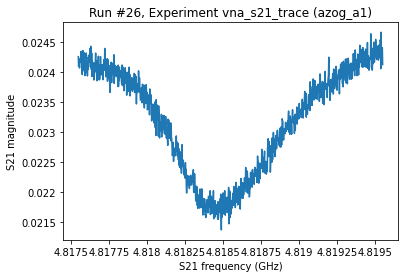

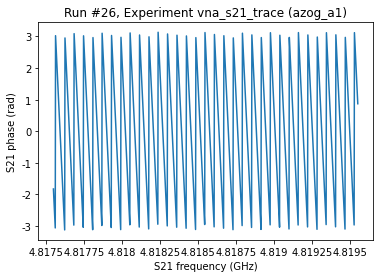

In [58]:
experiment_name = 'vna_s21_trace'
measurement_name = 'resonance_4.8'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

s21.center(4.81855e9)
s21.npts(1001)
s21.span(2e6)
s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(10)
s21.power(-30)

s21.set_electrical_delay_auto()
s21.average_clear()

vna.rf_on()
res = do0d(s21.trace_mag_phase, measurement_name=measurement_name);
vna.rf_off()

res[0].captured_run_id

Starting experimental run with id: 116. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/10 [00:00<?, ?it/s]

116

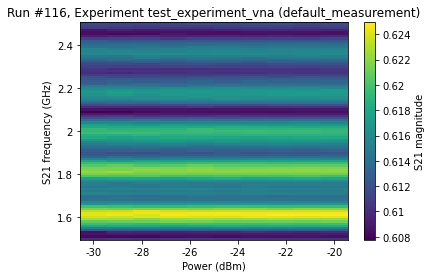

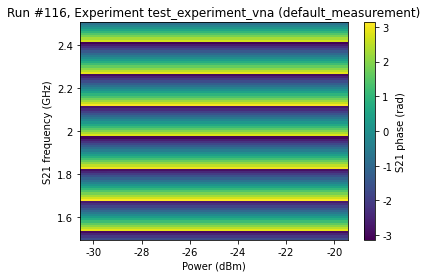

In [15]:
experiment_name = 'test_experiment_vna'
measurement_name = 'supercool_2d_vna'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

s21.center(2e9)
s21.span(1e9)
s21.bandwidth(1e3)
s21.npts(101)
s21.averaging_enabled(True)
s21.avg(10)
s21.power(-30)
s21.set_electrical_delay_auto()

vna.rf_on()
res = do1d(s21.power, -30, -20, 10, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
vna.rf_off()

res[0].captured_run_id

<h3 style="color:#418FDB";>Microwave measurement with VNA and signal generator</h3>

Starting experimental run with id: 117. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/10 [00:00<?, ?it/s]

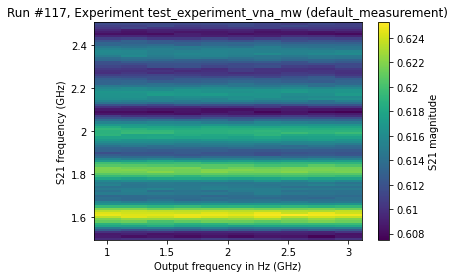

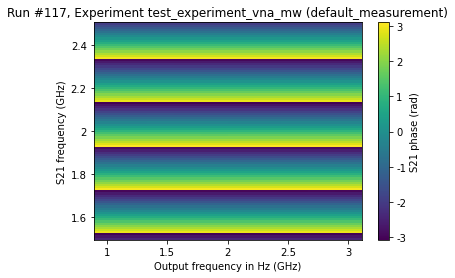

In [16]:
experiment_name = 'test_experiment_vna_mw'
measurement_name = 'supercool_vna_cw'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the vna parameters
s21.center(2e9)
s21.span(1e9)
s21.bandwidth(1e3)
s21.npts(101)
s21.averaging_enabled(True)
s21.avg(10)
s21.power(-30)
s21.set_electrical_delay_auto()

# set the signal generator parameters
mw_source.sourcemode('CW')
mw_source.power(-20)
mw_source.phase(0)

vna.rf_on()
mw_source.status('ON')
res = do1d(mw_source.frequency, 1e9, 3e9, 10, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
mw_source.status('OFF')
vna.rf_off()

<h4  style="color:#4697E8";>VNA CW and signal generator frequency sweep (two tones spectroscopy)</h4>

In [52]:
experiment_name = 'two_tones_test'
measurement_name = 'meas_4.8_tone_0.1_10'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the vna parameters
s21.center(4.8185e9)
s21.npts(1)
s21.bandwidth(1e3)
#s21.span(1e3)
s21.averaging_enabled(True)
s21.avg(10)
s21.power(-40)
#s21.set_electrical_delay_auto()

# set the signal generator parameters
mw_source.sourcemode('CW')
mw_source.power(-20)
mw_source.phase(0)

start_frequency = 100e6
stop_frequency = 10e9
step_frequency = 1e6
n_points = int( (stop_frequency-start_frequency)/step_frequency )
dwell_time = 0.01

# WARNING! It takes too much time for some reasons
vna.rf_on()
mw_source.status('ON')
res = do1d(mw_source.frequency, start_frequency, stop_frequency, n_points, dwell_time, s21.trace_mag_phase, measurement_name=measurement_name, do_plot=False);
mw_source.status('OFF')
vna.rf_off()

# maybe it would be good to improve the plotting of the results
runID = res[0].captured_run_id
x = res[0].get_parameter_data('mw_source_frequency')['mw_source_frequency']['mw_source_frequency']
y = res[0].get_parameter_data('ZNB20_S21_phase')['ZNB20_S21_phase']['ZNB20_S21_phase']
plt.plot(x[::2], y)

# add function that creates a measurements log file

Starting experimental run with id: 22. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/9900 [00:00<?, ?it/s]

2021-10-17 12:55:30,671 ¦ qcodes.dataset.measurements ¦ WARNING ¦ measurements ¦ __exit__ ¦ 646 ¦ An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-017c8de4619c;
Traceback:
Traceback (most recent call last):
  File "C:\Users\nicolas.roch\Measurements\Scripts\QMETfunc\QMET_measurement.py", line 288, in do1d
    (param_set, set_point), *call_param_meas(), *additional_setpoints_data
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\utils\threading.py", line 193, in _call_params
    output.append((parameter, parameter.get()))
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\instrument\parameter.py", line 637, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "C:\Users\nicolas.roch\Measurements\Drivers\VNA_ZNB20.py", line 241, in get_raw
    data = self.instrument._get_sweep_data(force_polar=True)
  File "C:\Users\nicolas.roch\Measurements\Drivers\VNA_ZNB20.py", line 878, in _get_sweep_

Received SIGINT, Will interrupt at first suitable time. Send second SIGINT to interrupt immediately.


KeyboardInterrupt: 

<h4  style="color:#4697E8";>VNA CW and signal generator power and frequency sweep (two tones spectroscopy)</h4>

In [60]:
experiment_name = 'two_tones_test'
measurement_name = 'meas_4.8_tone_0.1_30'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the vna parameters
s21.center(4.8182e9)
s21.npts(1)
s21.bandwidth(1e2)
#s21.span(1e3)
s21.averaging_enabled(True)
s21.avg(2)
s21.power(-30)
#s21.set_electrical_delay_auto()

# set the signal generator parameters
mw_source.sourcemode('CW')
mw_source.phase(0)

start_frequency = 100e6
stop_frequency = 20e9
step_frequency = .2e6
frequency_points = int( (stop_frequency-start_frequency)/step_frequency )

start_power = -30
stop_power = 3
step_power = 0.5
power_points = int( (stop_power-start_power)/step_power )

dwell_time = 0.005

# WARNING! It takes too much time for some reasons
vna.rf_on()
mw_source.status('ON')
res = do2d(mw_source.power, start_power, stop_power, power_points, dwell_time,
           mw_source.frequency, start_frequency, stop_frequency, n_points, dwell_time, 
           s21.trace_mag_phase, measurement_name=measurement_name, do_plot=False);
mw_source.status('OFF')
vna.rf_off()

# maybe it would be good to improve the plotting of the results
#runID = res[0].captured_run_id
#x = res[0].get_parameter_data('mw_source_frequency')['mw_source_frequency']['mw_source_frequency']
#y = res[0].get_parameter_data('ZNB20_S21_phase')['ZNB20_S21_phase']['ZNB20_S21_phase']
#plt.plot(x[::2], y)

# add function that creates a measurements log file

Starting experimental run with id: 27. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

<h4 style="color:#4697E8";>Only ADwin</h4>

In [18]:
experiment_name = 'test_experiment_adwin'
measurement_name = 'supercool_this_adwin'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the adwin parameters


<h2 style="color:#1C3C5C";>Data preview</h2>
Using the experiments widget to look at all the measurements in the database, or filter them by experiment.

In [5]:
experiments = qc.experiments()                       # define the experiments
#data_sets = experiments[0].data_sets()               # selecto only one experiment
#experiments_widget(data_sets=data_sets)              # start the widget on the selected experiment

experiments_widget(db=qc.config.core.db_location)  # start the widget on the whole database

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

